<a href="https://colab.research.google.com/github/Nuthan03/SkimLit/blob/main/SkimLit_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: SkimLit

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper [*PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts*](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

![Skimlit example inputs and outputs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)

*Example inputs ([harder to read abstract from PubMed](https://pubmed.ncbi.nlm.nih.gov/28942748/)) and outputs ([easier to read abstract](https://pubmed.ncbi.nlm.nih.gov/32537182/)) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.*

## Confirm access to GPU


In [1]:
!nvidia-smi

Tue Dec 19 06:02:46 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Get data

Since we'll be replicating the paper above (PubMed 200k RCT), let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct.git

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.34 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/
!ls pubmed-rct/PubMed_20k_RCT/

dev.txt  test.txt  train.txt
dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k with numbers replaced by "@" sign

data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we have got some text data, it's time to become one with it.
And one of the best ways to become one with the data is to..

> Visualize, Visualize, Visualize

So that in mind, let's write a function to read in all of the lines of a target text file.


In [6]:
# Create a function to read the lines of a doc

def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from teh target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [8]:
len(train_lines)

210040

Let's think about how we want our data to look..

How i think our data would be best represented...

```
[{
  'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
  ```

Let's write a function which turns each of our datasets into the above foramt so we can continue to prepare our data for modelling.

In [9]:
def preprocess_text_with_line_number(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Take in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence
  number the target line is.
  """
  input_lines = get_lines(filename) # Get all lines from filenames
  abstract_lines = "" # create an empty abstracts
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith('###'): # Checks to see if there is any ID lines
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    elif line.isspace():# Check to see if line is a new line
       abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

       # Iterate through each line in a single abstracta and count them at the same time
       for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # Create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # Get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) -1 # how many total lines are there in the target abstract?
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples

In [10]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_number(data_dir +"train.txt")
val_samples = preprocess_text_with_line_number(data_dir +"dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_number(data_dir +"test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 752 ms, sys: 135 ms, total: 887 ms
Wall time: 1.06 s


(180040, 30212, 30135)

In [11]:
# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it.

In [12]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [13]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

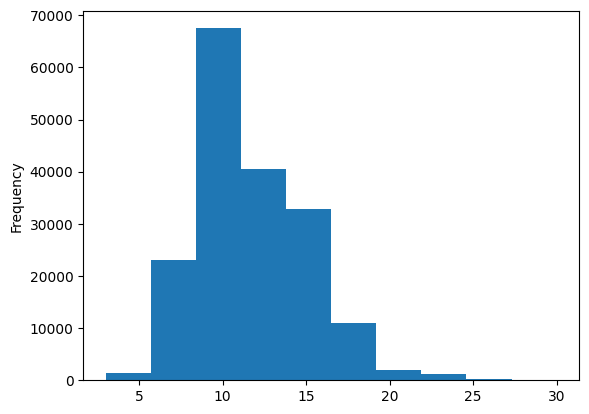

In [14]:
# Let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lsits of sentences

In [15]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [16]:
# View the 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels(ML models require numeric labels)

In [17]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

#Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

## Label encode labels

In [18]:
# Extract label's ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded =label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels took like
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [19]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Starting a series of modeling experiments..

As usual, we are going to be trying out a bunch of different model and seeing which one works best.

And as always, we are going to start with a baseline(Tf-IDF Multinomial Naive Bayes classifier).


## Model 0: Getting a baseline

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the training dat
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [21]:
# Evaluate baseline model on validation datasets
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [22]:
# Make some predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [23]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper functions script

Let's get our `helper_function.py` script we've been using to store helper we've created in previous notebooks.

In [24]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-19 06:03:20--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-19 06:03:20 (105 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [25]:
from helper_functions import calculate_results

In [26]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [27]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data for deep sequence models

Before we start building deeper models, we've got to create vectorization and embedding layers.

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [29]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

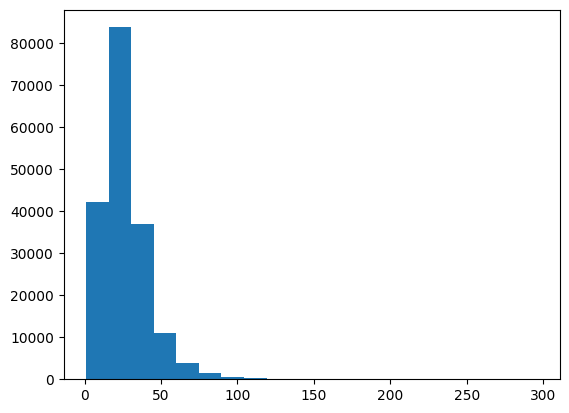

In [30]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [31]:
# How long of a sentence covers 95% of the lenghts?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [32]:
# Maximum sequence length in the training set
max(sent_lens)

296

## Create text vectorizer layer

We want to make a layer which maps our texts from words to numbers.

In [33]:
# How many words are there in our vocab? (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)
max_tokens = 68000

In [34]:
# Create text vectorizer
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens, # number of words in vocabulary
                                    output_sequence_length=55) # desired output length of vectorized sequences

In [35]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [36]:
# Test out text vectorizer
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: \n{text_vectorizer([target_sentence])}")

Text:
nct@ and nct@ .

Length of text: 4

Vectorized text: 
[[176   3 176   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]


In [37]:
# How many words in our training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [38]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [39]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               # Use masking to handel variable sequence lengths
                               mask_zero=True,
                               name="token_embedding")

In [40]:
# Show example embedding
print(f"Sentence before vectorization:\n {target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n {vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n {embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
 nct@ and nct@ .

Sentence after vectorization (before embedding):
 [[176   3 176   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]

Sentence after embedding:
 [[[-0.03956763 -0.03177099 -0.00579184 ...  0.04455564  0.03115096
    0.03977411]
  [-0.00980388  0.04774323  0.04554207 ...  0.00057561  0.04388566
    0.03842722]
  [-0.03956763 -0.03177099 -0.00579184 ...  0.04455564  0.03115096
    0.03977411]
  ...
  [-0.01275577  0.02053163 -0.03416697 ...  0.02071271 -0.00864217
    0.03083763]
  [-0.01275577  0.02053163 -0.03416697 ...  0.02071271 -0.00864217
    0.03083763]
  [-0.01275577  0.02053163 -0.03416697 ...  0.02071271 -0.00864217
    0.03083763]]]

Embedded sentence shape: (1, 55, 128)


## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with TensorFlow tf.data API, many of the steps here are discussed at length in these two resources:
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)
* [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance)

In [41]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [42]:
# Take the tensorSliceDataset's and turn them into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [43]:
# Create 1D convolutional model to process sequence
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

In [44]:
# Compile model_1
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [45]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 22s 33ms/step - loss: 0.9224 - accuracy: 0.6340 - val_loss: 0.6909 - val_accuracy: 0.7324
Epoch 2/3
562/562 [==============================] - 7s 12ms/step - loss: 0.6633 - accuracy: 0.7540 - val_loss: 0.6365 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 6s 10ms/step - loss: 0.6224 - accuracy: 0.7740 - val_loss: 0.5994 - val_accuracy: 0.7829


In [46]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [47]:
# Evaluate the model
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6016 - accuracy: 0.7854


[0.6015523076057434, 0.7853502035140991]

In [48]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

945/945 [==============================] - 2s 2ms/step


array([[4.4543555e-01, 1.9955325e-01, 6.4688407e-02, 2.6472786e-01,
        2.5594926e-02],
       [4.0208995e-01, 3.4464642e-01, 1.0249199e-02, 2.3581183e-01,
        7.2025401e-03],
       [1.6071741e-01, 9.6066892e-03, 1.9782076e-03, 8.2765925e-01,
        3.8336744e-05],
       ...,
       [6.6127313e-06, 8.9276012e-04, 6.8966101e-04, 2.5378688e-06,
        9.9840850e-01],
       [4.5760825e-02, 5.1495451e-01, 7.5827055e-02, 5.2231677e-02,
        3.1122595e-01],
       [2.1003123e-01, 5.7296807e-01, 6.1650861e-02, 6.6238604e-02,
        8.9111231e-02]], dtype=float32)

In [49]:
# Convert pred probs to classes
model_1_pred = tf.argmax(model_1_pred_probs, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [50]:
model_1_results = calculate_results(y_true = val_labels_encoded,
                                    y_pred=model_1_pred)
model_1_results

{'accuracy': 78.5350191976698,
 'precision': 0.7822483080218572,
 'recall': 0.785350191976698,
 'f1': 0.7829208447317425}

In [51]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 2: Feature extraction with pretrained token embeddings

Now let's use pretrained word embeddings from TensorFlow Hub more specifically the universal sentnce encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings, however, we're going to stick with the later created USE pretrained embeddings.


In [52]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [53]:
# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedding_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n {use_embedding_sentence[0][:30]}\n")
print(f"Length of sentence embedding:\n{len(use_embedding_sentence[0])}")

Random sentence:
 eight patients ( @ % ) -lsb- group a , n = @ patients ( @ % ) vs. group b , n = @ patients ( @ % ) ; p = @ -rsb- developed immediate ( @ ) or delayed ( @ ) bleeding .
Sentence after embedding:
 [-0.03702921 -0.06843379  0.01202601  0.03834258 -0.03022717 -0.01926979
  0.05268388 -0.00878416 -0.06811869  0.00620887  0.07725307 -0.01885057
  0.07496721  0.05929875  0.04229502 -0.0058295  -0.07759532 -0.07000868
 -0.06930874  0.00680925  0.07676828  0.05028755 -0.04616522 -0.06482257
 -0.00097462 -0.04387202 -0.02612682 -0.00617195 -0.04020721 -0.06324021]

Length of sentence embedding:
512


## Building and fitting and NLP feature extraction model from TensorFloww Hub

In [54]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequence (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(5, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

In [55]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [56]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 13ms/step - loss: 0.9171 - accuracy: 0.6505 - val_loss: 0.7966 - val_accuracy: 0.6868
Epoch 2/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7699 - accuracy: 0.7018 - val_loss: 0.7554 - val_accuracy: 0.7055
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7543 - accuracy: 0.7114 - val_loss: 0.7388 - val_accuracy: 0.7148


In [57]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [58]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.7417 - accuracy: 0.7148


[0.7417410612106323, 0.7148483991622925]

In [59]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 9s 9ms/step


array([[4.2060518e-01, 3.7402433e-01, 2.7178086e-03, 1.9410308e-01,
        8.5495897e-03],
       [3.8916427e-01, 4.5239052e-01, 4.3037422e-03, 1.5042186e-01,
        3.7195634e-03],
       [2.1842912e-01, 1.5362310e-01, 1.7173842e-02, 5.7272160e-01,
        3.8052324e-02],
       ...,
       [1.8439156e-03, 5.0399634e-03, 5.3422287e-02, 8.9191226e-04,
        9.3880188e-01],
       [3.7619756e-03, 4.6833452e-02, 1.9601956e-01, 1.1401915e-03,
        7.5224477e-01],
       [1.5002191e-01, 2.2190146e-01, 5.6182164e-01, 4.9419580e-03,
        6.1313011e-02]], dtype=float32)

In [60]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [61]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                            y_pred=model_2_preds)
model_2_results

{'accuracy': 71.48484046074407,
 'precision': 0.7151713490866597,
 'recall': 0.7148484046074407,
 'f1': 0.7118034620857312}

In [62]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [63]:
model_2_results

{'accuracy': 71.48484046074407,
 'precision': 0.7151713490866597,
 'recall': 0.7148484046074407,
 'f1': 0.7118034620857312}

## Model 3: Conv1D with character embeddings

The paper which we're replicating states they used a combination of token and character-level embeddings.
Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings

### Creating a character-level tokenizer

In [64]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character-level sequence into characters
split_chars(random_train_sentence)

'e i g h t   p a t i e n t s   (   @   %   )   - l s b -   g r o u p   a   ,   n   =   @   p a t i e n t s   (   @   %   )   v s .   g r o u p   b   ,   n   =   @   p a t i e n t s   (   @   %   )   ;   p   =   @   - r s b -   d e v e l o p e d   i m m e d i a t e   (   @   )   o r   d e l a y e d   (   @   )   b l e e d i n g   .'

In [65]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [66]:
# Whats the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

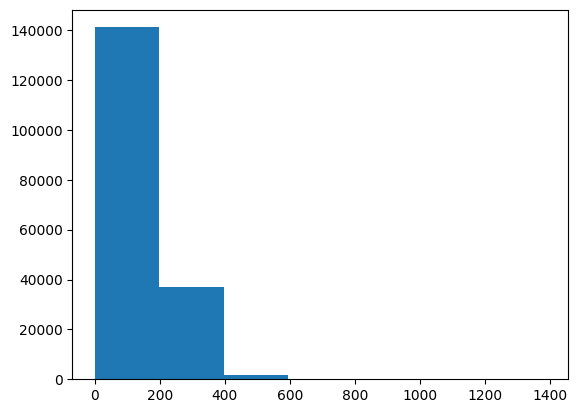

In [67]:
# Check the distribution of our sequence at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [68]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [69]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab, ['UNK])
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

In [71]:
# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

In [72]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [73]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
 s e r u m   c y t o k i n e   c o n c e n t r a t i o n s   a n d   e x   v i v o   c y t o k i n e   p r o d u c t i o n   (   b o t h   m o n o c y t e   a n d   t - c e l l   d e r i v e d   )   d i d   n o t   d i f f e r   d u r i n g   t r e a t m e n t   w i t h   v i l d a g l i p t i n   c o m p a r e d   t o   a c a r b o s e   .

Length of random_train_chars: 146

Vectorized chars:
 [[ 9  2  8 16 15 11 19  3  7 23  4  6  2 11  7  6 11  2  6  3  8  5  3  4
   7  6  9  5  6 10  2 24 21  4 21  7 11 19  3  7 23  4  6  2 14  8  7 10
  16 11  3  4  7  6 22  7  3 13 15  7  6  7 11 19  3  2  5  6 10  3 11  2
  12 12 10  2  8  4 21  2 10 10  4 10  6  7  3 10  4 17 17  2  8 10 16  8
   4  6 18  3  8  2  5  3 15  2  6  3 20  4  3 13 21  4 12 10  5 18 12  4
  14  3  4  6 11  7 15 14  5  8  2 10  3  7  5 11  5  8 22  7  9  2  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 

## Creating a charcter-level embedding

In [74]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vedtorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
s e r u m   c y t o k i n e   c o n c e n t r a t i o n s   a n d   e x   v i v o   c y t o k i n e   p r o d u c t i o n   (   b o t h   m o n o c y t e   a n d   t - c e l l   d e r i v e d   )   d i d   n o t   d i f f e r   d u r i n g   t r e a t m e n t   w i t h   v i l d a g l i p t i n   c o m p a r e d   t o   a c a r b o s e   .

Embedded chars (after vedtorization and embedding):
[[[ 0.01889714  0.00809639  0.02379567 ...  0.04487029  0.03279093
    0.00729339]
  [ 0.03370533 -0.01083701  0.02115632 ...  0.01644475  0.03423871
    0.02511325]
  [-0.01828747  0.04775542 -0.00985532 ... -0.00987717  0.00966939
   -0.02771093]
  ...
  [-0.00694258  0.03482087  0.02452881 ...  0.0040428  -0.04791597
   -0.03018622]
  [-0.00694258  0.03482087  0.02452881 ...  0.0040428  -0.04791597
   -0.03018622]
  [-0.00694258  0.03482087  0.02452881 ...  0.0040428  -0.04791597
   -0.03018622]]]

Character embedding shape: (1, 290, 25)


## Building a Conv1D model to fit on character embeddings

In [75]:
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

In [76]:
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [77]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5

In [78]:
# Create char datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [79]:
model_3.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=3,
            validation_data = val_char_dataset,
            validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 5s 6ms/step - loss: 1.2633 - accuracy: 0.4880 - val_loss: 1.0445 - val_accuracy: 0.5821
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 1.0181 - accuracy: 0.5889 - val_loss: 0.9512 - val_accuracy: 0.6180
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 0.9458 - accuracy: 0.6278 - val_loss: 0.8850 - val_accuracy: 0.6529


In [80]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.9095 - accuracy: 0.6451


[0.9094648957252502, 0.6451079249382019]

In [81]:
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_pred_probs

945/945 [==============================] - 3s 3ms/step


array([[0.15510853, 0.4245694 , 0.07918712, 0.27512887, 0.06600606],
       [0.14048715, 0.55674684, 0.04893418, 0.1896526 , 0.06417919],
       [0.06108017, 0.27715817, 0.27305606, 0.19292995, 0.1957757 ],
       ...,
       [0.01346128, 0.03087533, 0.12639254, 0.02473035, 0.8045406 ],
       [0.01679678, 0.08920725, 0.5399881 , 0.02309558, 0.33091238],
       [0.3794397 , 0.4217141 , 0.11466944, 0.07749479, 0.00668201]],
      dtype=float32)

In [82]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 1, ..., 4, 2, 1])>

In [83]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 64.51079041440487,
 'precision': 0.6382783814914048,
 'recall': 0.6451079041440487,
 'f1': 0.6351406490157808}

In [84]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. Create a token-level model(similar to `model_1`)
2. Create a character-level model(similar to `model_3` with a slight modification to reflect the paper)
3. Combine (using [`layers.Concatenate`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate)) the outputs of 1 and 2
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of  [*Neural Networks for Joint Sentence Classification
in Medical Paper Abstracts*](https://arxiv.org/pdf/1612.05251.pdf)
5. Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [85]:
# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2.Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Concatenate token and char inouts (create hybrid token embedding)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output,
                                                                  char_model.output])

# 4. Create output layers - adding in Dropout discussed in 4.2 of https://arxiv.org/pdf/1612.05251.pdf
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)


# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

In [86]:
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token_input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char_input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978 

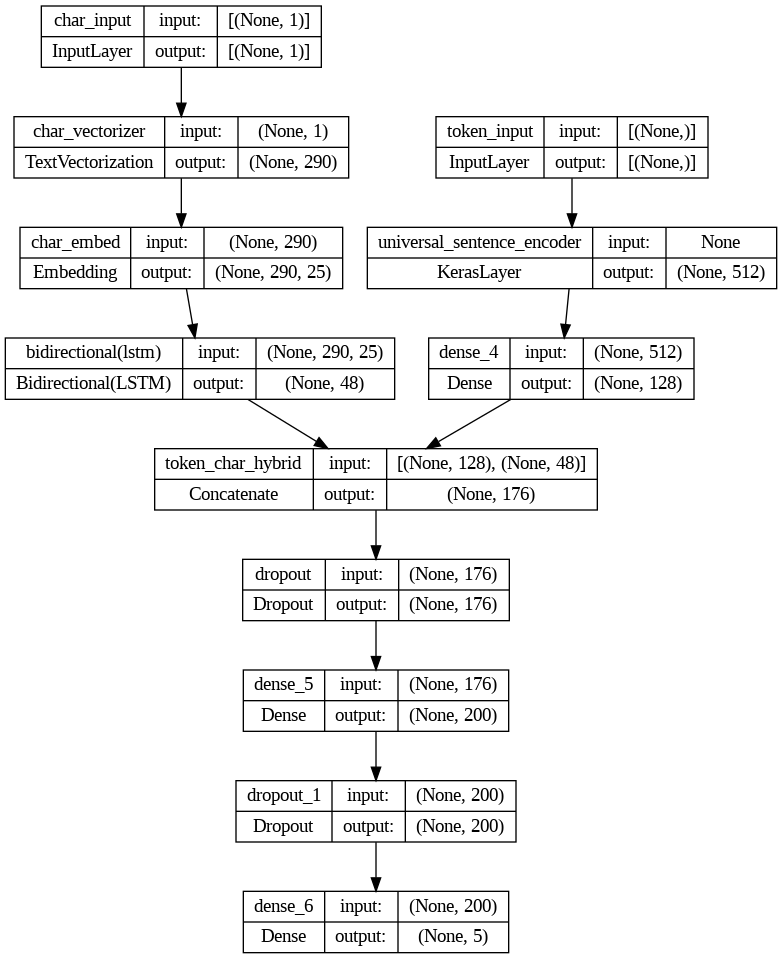

In [88]:
# Plot hybrid token and character model
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [95]:
# Compile
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

### Combining token and character data into a `tf.data` dataset

In [96]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [97]:
# Check out our training char and token embedding dataset
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

### Fitting a model on token and character-level sequences

In [98]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 28s 39ms/step - loss: 0.9708 - accuracy: 0.6113 - val_loss: 0.7845 - val_accuracy: 0.7005
Epoch 2/3
562/562 [==============================] - 29s 52ms/step - loss: 0.7910 - accuracy: 0.6941 - val_loss: 0.7083 - val_accuracy: 0.7287
Epoch 3/3
562/562 [==============================] - 29s 52ms/step - loss: 0.7657 - accuracy: 0.7045 - val_loss: 0.6899 - val_accuracy: 0.7367


In [99]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6940 - accuracy: 0.7354


[0.694027841091156, 0.7354362607002258]

In [100]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 [==============================] - 21s 20ms/step


array([[4.7552258e-01, 2.7851346e-01, 3.9507719e-03, 2.3420067e-01,
        7.8125559e-03],
       [3.3232176e-01, 4.5200869e-01, 2.0571090e-03, 2.1146320e-01,
        2.1491777e-03],
       [3.1217152e-01, 6.4151280e-02, 4.6211120e-02, 5.4924083e-01,
        2.8225252e-02],
       ...,
       [4.4312648e-04, 6.0714930e-03, 4.3866266e-02, 1.9293223e-04,
        9.4942623e-01],
       [8.0150841e-03, 7.1598507e-02, 2.1479294e-01, 4.6622534e-03,
        7.0093125e-01],
       [3.1541786e-01, 3.1745732e-01, 2.8132159e-01, 4.0824976e-02,
        4.4978295e-02]], dtype=float32)

In [101]:
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)
model_4_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [104]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_pred)
model_4_results

{'accuracy': 73.54362504964914,
 'precision': 0.736410379735425,
 'recall': 0.7354362504964914,
 'f1': 0.7333150154634736}

In [105]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}